# Project Overview

This report investigates the variables that influence the cost of basic goods. 

## Data Collection

46 undergraduate volunteers were dispatched to two grocery stores each, collecting price information for 10 sets of products. 3 samples were collected for each product, where each sample included an observed price and observed quantity (for example, 5 Euros for 2 kilos of apples). 

In addition to price information, volunteers reported their present country, currency used in the prices of goods (eg. USD), grocery store addresses, brand perception of the grocery stores (eg. Luxury), as well as the neighborhood average rental prices per month for a 'standard' apartment or home. 

After cleaning (see Technical Appendix), we have 4 sets of categoricals: 4 countries (US, UK, South Korea and Germany), 3 brands (Budget, Mid-Range and Luxury), 10 Product (Apples, Bananas, Tomatoes, Potatoes, Flour, Rice, Milk, Butter, Eggs, Chicken) and 4 Neighborhood categories. We also have two continuous variables: Price and average Rental Prices.

# Model 1: Country-Level Model

## Specification

The likelihood function is simulated through,

$$ \text{Price} \sim  \text{Normal}(base_{\text{p}} * brand_{\text{br}} * country_{\text{c}}, \sigma_{\text{p}})$$

Where,

$base_{\text{p}}$ denotes the base price of a respective product, $p = 1 \dots 10$,

$brand_{\text{br}}$ denotes the brand muliplier, $b = 1 \dots 3$,

$country_{\text{c}}$ denotes the country muliplier, $c = 1 \dots 4$,

$\sigma_{\text{p}}$ denotes error associated with each product, $p = 1 \dots 3$


This specification suggests that a product price will be centered around the base price scaled by multipliers, with random variation captured by the error ter sigma for a respective product. For example, bananas found to be priced at 2 EUR/kilo in **a mid-range store** in **Germany** could be decomposed into $ N(1.5*1.1*1.2, 0.1)$, where 1.5 EUR is the **standardized base price of bananas** (in EUR), 1.1 is the multiplier for **a mid-range store**, while 1.2 is the multiplier for **Germany**. 

The task of the inference procedure is to fit each base price, brand multiplier and country multiplier. After due preprocessing, there are a total of 10 products (and therefore, base prices), 3 brands (budget, mid-range and luxury) and 4 countries (USA, UK, Germany and South Korea. This leads into the full Bayesian specification for 27 parameters and the data $y$,

$$ p(\sigma_{\text{p}}, base_{\text{p}},brand_{\text{br}}, brand_{\text{c}} \vert y) \propto \text{Normal}(base_{\text{p}} * brand_{\text{br}} * country_{\text{c}}, \sigma_{\text{p}})p(base_{\text{p}}) p(brand_{\text{br}}) p(country_{\text{c}}) p(\sigma_{\text{p}})$$

A clear limitation is that the model assumes the brand and country categories are exhaustive. This is not true, as we know there are greater than 4 countries in the world. In other words, when faced with a prediction problem involving an unobserved country like India, the posterior predictive will not be well defined the corresponding unobserved country multiplier. Additionally, the following assumptions must also be outlined:

1. IID. The model assumes independent and identically distributed base prices. A consequence is that multipliers apply homogenously, regardless of whether the product is an apple or banana. A more specific model would incoporate, for example, how a 'bio' store has highly priced organic produce. 
2. No serial autocorrelations in Price data. The model assumes that price data was collected at approximately the same time, such that prices do not change over the course of the collection procedure. This is a safe assumption to make as all data was collected over the course of about a week. 
3. Good reporting. The meta-assumption is that data was collected diligently and is without fabrications or modifications. This might be the hardest to assume true, given the volunteerism.

### Priors

In the full specification, the latter terms $p(base_{\text{p}}) p(brand_{\text{br}}) p(country_{\text{c}}) p(\sigma_{\text{p}})$ outline the priors. These were given the following distributions, with a brief rationale:

$p(base_{\text{p}})    \sim \text{Cauchy(0,50)}$, as we want the data to inform the choice of base prices as much as possible, so the prior over prices needs to be broad and modestly informative. The full Cauchy prior is notably defined at negative values, which imply nonsensical negative prices. We circumvent this by specifying a half-Cauchy in the Stan code; a half cauchy is truncated at 0 and monotonically decreases over price, capturing the intuition that the cost of basic goods should, well, basically be inexpensive. 

$p(brand_{\text{br}})  \sim \text{LogNormal(0,0.25)}$, as we want multiplicative effects to *not* dominate base prices. These hyperparameters inform a log-normal with a median of 1 and mean of 1.33, while shortening the right tail to 3 on the 99th percentile. The support of this is also restricted to positive real numbers, as we want to eliminate parameter candidates which yield negative prices.

$p(country_{\text{c}}) \sim \text{LogNormal(0,0.25)}$, as we similarly want moderate multiplicative effects. Between the two multiplier priors, we encode the majority of our prior beliefs about price behavior.

$p(\sigma_{\text{p}})  \sim \text{InvGamma(2,1.5)}$, as the support is positive $x \in {0, \infty}$, and we must have a positive real for the variance parameter in the Normal likelihood. This distribution is sharp and long-tailed, capturing the idea that, conditioned on brand, product and location, the variation in price data is very mild. This is plausibly an assumption that needs to be relaxed. 


## Model 2: Berlin Neighborhood-Level

The previous model sweeps the full gamut of the collected data, using as many datum as possible, but in the process is quite possibly too general. The following model disaggregates the scope of the Country-Level model to the level of Berlin Neighborhoods, the most sampled city. This is incurred in a minor change to the likelihood, 

$$ \text{Price} \sim  \text{Normal}(base_{\text{p}} * brand_{\text{br}} * neighborhood_{\text{n}}, \sigma_{\text{p}})$$

Where we have the new term,

$neighborhood_{\text{n}}$, the multiplier for each neighborhood $n = 1 \dots 9$. 

The prior over neighborhood multipliers is exactly as before, with $LogNormal(0,0.5)$. In summary, we are swtiching out countries for neighborhoods. 

## Model 2.1: Berlin Neighborhood-Level (with Spatial Correlations)

Viewed on a map, the 9 sampled neighborhoods in Berlin 'tile' together - each neighborhood is connected to another neighborhood by sharing a boundary. This configuration lends naturally to describing the neighborhoods with an adjacency matrix $W_{ij}$, where 1 implies a shared boundary between neighborhood_i and neighborhood_j and 0 implies no shared boundary, or, distance. 

The CAR (Conditional AutoRegressive) prior models spatial correlations around spatial lattices, of which the adjacency matrix is a kind. We will use the CAR prior to capture the idea that neighborhoods close together will have similar prices, while neighborhoods far apart (ie not sharing a boundary) will have dissimilar prices. 

The author suggests introducing a CAR prior and a modified likelihood to account for these spatial effects in a reproduction.  


### (Addendum) Data Preprocessing

To fare well with the Stan modeling paradigm, collected price data underwent two transformations: reshaping the dataframe to a format that stan can read row-by-row, and encoding each categorical (Product Type, Brand, Country, Neighborhood) such that Stan can index each parameter perfectly.

The data was also transformed to convert currency to a standard of EUR, standardize units (EUR/kilo) and also drop significant outliers that indicated poor data collection. Each of these are described in detail in the Technical Appendix. 

# Analysis

After fitting the model in Stan, the results of the inference procedure are summarized and interpreted below. A full table of results, including convergence data on the sampling procedure, is listed and interpreted in the Technical Appendix.

We begin by analyzing the basic average proces for each product. The following plot visualized the posterior samples of base prices, 

![Base Prices](/Users/andrevacha/Desktop/cs146/LBA/base.jpg)

The plot, sorted according to mean base price, confirm what we (hope) to be true abot the mean cost of basic foods: carbohydrate staples (flour and rice) are inexpensive, meat and butter cost more, while 80% products fall below 5 euros. As these are posteriors, however, we also have information about how we expect these to vary. Eggs, Milk, Flour and Potatoes show little spread, perhaps evincing the high price sensitivity associated with inferior goods. Meanwhile, normal goods like Chicken, Tomatoes and Apples that can be differentiated according to, say, lifestyle trends (organic, bio, local souring, free range), experience wider spread. This is most notable with rice, a staple grain and diet staple in the majority of the world, which has a high mean of about 5 EUR/kilo and wide spread. I personally saw the tagline "sourced from India" on a Basmati rice label. 

$$
\begin{tabular}{lrr}
\toprule
Product &   Mean &   Std \\
\midrule
Apples          &   4.32 &  0.91 \\
Bananas         &   2.33 &  0.50 \\
Butter          &  11.18 &  2.37 \\
Chicken Breasts &  14.50 &  3.13 \\
Eggs            &   0.46 &  0.10 \\
Flour           &   1.83 &  0.40 \\
Milk            &   1.57 &  0.34 \\
Potatoes        &   2.03 &  0.44 \\
Rice            &   5.27 &  1.14 \\
Tomatoes        &   5.36 &  1.16 \\
\bottomrule
\end{tabular}
$$

Examining these prices, however, requires interpretive nuance. Since a price is modelled by multiplying a base price with multipliers, we can *expect* to see variation around these base prices conditioned on a pair of multipliers: 

![Multipliers](/Users/andrevacha/Desktop/cs146/LBA/multipliers.jpg)

For example, while a bunch of bananas in Germany in a mid-range store has a base price of 2.33 EUR/kilogram, its *expected* final price *decreases* to 1.72 EUR/kilo. However, the plot above describes inconclusive multiplier effects. 

$$
\begin{tabular}{lrr}
\toprule
Product &  Mean &  Std \\
\midrule
Germany            &  0.86 &  0.11 \\
Seoul              &  0.75 &  0.11 \\
UK                 &  0.93 &  0.12 \\
United States      &  0.96 &  0.16 \\
Budget (cheap)     &  0.83 &  0.13 \\
Luxury (expensive) &  0.81 &  0.13 \\
Mid-range          &  0.86 &  0.13 \\
\bottomrule
\end{tabular}
$$

In other words, since the posterior distributions for brand multipliers significantly overlap, we both have wide uncertainty over the value of *all* multipliers, as well as uncertainty over the effect of one over the other. To illustrate, we expect Luxury stores to have a high brand multiplier as goods sold there tend to be higher priced. The expected Luxury multiplier is in fact the *lowest* of the three multipliers by a small amount. We cannot use this to claim that luxury stores are the least expensive *overall* because of the wide variance in posterior samples, and how this variance encloses the other brand multipliers. The inconclusive brand multipliers are a consequence of a (tragically) low sample size. While we have 900 data points for Mid-range stores, we have just 140 for luxury stores. It is advised that a reproduction of the model perform random as opposed to convenience sampling to better represent luxury and mid-range stores. 

On the other hand, country multipliers are slightly more conclusive. The differences in the expected values of countries are significant: 0.75 in Seoul to 0.96 in US is a 28% difference in prices, conditioned on the same product and brand. However, and as before, there is overlap in the multiplier distributions as a consequence of high variance. If we chart multipliers against the country's respective Groceries Index (obtained from [Number](https://www.numbeo.com/cost-of-living/rankings_by_country.jsp?title=2021-mid&displayColumn=3)), the problems of small sample size (there are just 25 data points for Seoul, while there are 792 for Germany) in this inference become apparent:

![Multiplier vs GPI](/Users/andrevacha/Desktop/cs146/LBA/countrymult.jpg)

Despite being much more expensive on the Grocery Price Index, South Korea has the smallest multiplier. Germany, UK and the US evince a positive trend in Grocery Price Index and Fitted Multipliers, however. This is presumably a consquence of a small sample size in Korea.

In sum, the base prices seem to account for the majority of the variations in price data. A new study with more data from each country and brand is required to obtain better estimates on multiplier effects.


### Neighborhood and Rental Price Correlation 

To ascertain the correlation of neighborhood average rental prices with the fitted neighborhood multiplier, we now examine the output of the Berlin Neighborhood-Level Model with multipliers over the following neighborhoods: Friedrichshain-Kreuzberg, Kreuzberg, Friedrichshain, Alexanderplatz, Botzowviertel, Neukolln, Alt-Treptow, Kollwitzkiez and the Samariter Quarter. 

![Neighborhood](/Users/andrevacha/Desktop/cs146/LBA/neighmult.png)

The plot suggests that nieghborhoods like the Samariter Quarter are *expected to be* more expensive than neighborhoods like Neukolln. However, the problem of wide variance continues to make strong claims about the effect of neighborhood multipliers on price more certain. To examine this further, consider the correlation between average rental prices in a neighborhood against the multiplier that we fit:

![Neighborhood vs Rental Prices](/Users/andrevacha/Desktop/cs146/LBA/neighborhood.jpg)

Counterintuitively, Average rental prices are weakly negatively correlated (-0.21) with the multipliers. There is also an egregious outlier in the Friedrichshain-Kreuzberg neighborhood that makes a regression model unfruitful. 

# Technical Appendix

Full code that can be run can be found [here](https://colab.research.google.com/drive/1wMKsa-vD_v3HAwXA8MnXCwfDMXbBy5YJ?usp=sharing).

In [ ]:
# Importing requisite libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install pystan
import pystan

## Preprocessing
The following code pipelines "responses.csv" - the raw data collected from 46 volunteers. Data is cleaned (mispellings, as well as labels for store neighborhoods are added), price data is converted to EUR, and each product is assigned a standardized price in kilos (with the exception of counts for eggs and liters for milk). Additionally, the shape of the dataframe is melted down to from (N,30) to about (N*10*3, 4). Disaggregated, the penalty for dropping missing values by dropping a row is substantially reduced. 

In [2]:
data = pd.read_csv("responses.csv")

# Fuzzy match on countries :: 4 countries
data["Country where you (and the grocery store) are"].replace(
    {
        "Berlin": "Germany",
        "United Kingdom": "UK",
        "London": "UK",
        "United Kindom": "UK",
        "Berlin, Germany": "Germany",
        "Germany ": "Germany",
        "United Kingdom ": "UK",
        "Berlin, Germany ": "Germany"
    },
    inplace = True
    )

# Clean rental price data, convert to int
data["Average rental price near the grocery store"] = data["Average rental price near the grocery store"].str.extract('(\d+)')

# Correcting the WOO anomaly
data.loc[data["Currency (e.g. EUR, GBP, USD)"] == "Korean Won", "Currency (e.g. EUR, GBP, USD)"] = "USD"

# Slice out price df and quantity df
prices = data.iloc[:,9::2]
quantities = data.iloc[:,8::2]

conversion_rates = {
        'EUR': 1,
        'GBP': 0.95,
        'USD': 0.91
    }

# Create exchange rate column
data['Exchange Rate'] = data.iloc[:, 4].apply(lambda x: conversion_rates[x])

# Convert to Euros
euro_prices = prices.mul(data['Exchange Rate'], axis = 0)
# Drop exchange rate column before we melt
# euro_prices = euro_prices.drop('Exchange Rate', axis = 0, inplace = True)

# Standardizing prices 
# :: cts for eggs will be microscopic but we can rescale later
std_prices = euro_prices.div(quantities.values)

# Melt to (N*10*3, 2)
flush_prices = pd.melt(std_prices)

# Recasting item names in main roles
items = ['Apples', 'Bananas', 'Tomatoes',
         'Potatoes', 'Flour', 'Rice', 'Milk',
         'Butter', 'Eggs', 'Chicken Breasts']

flush_prices = flush_prices.replace(
               r'Product [0-9] price$', 0, regex = True).replace(
               r'Product [0-9] price.([0-9])', r'\1', regex = True)

# Change names
flush_prices.variable = flush_prices.variable.astype('int').replace({i : items[i] for i in range(len(items))})

# Add country and brand data, similarly melted
# Perform a Series melt through repetition
countries = data["Country where you (and the grocery store) are"].repeat(prices.shape[1])
brands = data["Price perception of the store brand"].repeat(prices.shape[1])

# Check shape
brands.value_counts() == data["Price perception of the store brand"].value_counts()*30
# Check the order for a selection
assert data.iloc[4,6] == brands.iloc[4*90]

# We can now safely drop NAs, without dropping rows
#straight_prices = flush_prices.dropna(axis = 0)
assert len(flush_prices.loc[flush_prices['variable'] == 0]) == data.shape[0]*3

## Data Cleaning

Due to measurement error, the data has incurred problematic outliers (notably, a ~$300/kg apple). These are explored and dropped using the following code. A samples of the largest values are reproduced. 

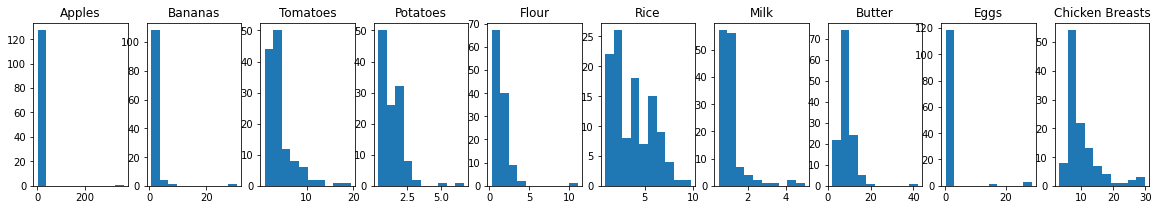

In [3]:
fig, axs = plt.subplots(ncols=10, figsize = (20,3))

for item, ax in zip(items, axs.flatten()):

    ax.hist(flush_prices.loc[flush_prices['variable'] == item, 'value'])
    ax.set_title(f'{item}')

In [ ]:
# Kill the $300/kg Apple
poison_apple = 52
# Humpty dumpty to the expensive eggs
expensive_eggs = flush_prices.loc[(flush_prices.variable == "Eggs") & (flush_prices.value > 5), :].index
clean_prices = flush_prices.drop([*expensive_eggs, poison_apple])

# See if extreme values are sensible
extrema = clean_prices.value.dropna().sort_values()[-10:]
clean_prices.loc[extrema.index, :]

## Fitting the Stan Model

To correctly bound indexing in the Stan code, each independent variable is assigned its category code. With a well-parsed data frame, we simply need to extract column values to pass to Stan in `model_data`

In [ ]:
# Reset index to support concat
countries = countries.reset_index().drop('index', axis = 1)
brands = brands.reset_index().drop('index', axis = 1)
model_data = pd.concat((flush_prices, countries, brands), axis = 1)

# Safely drop nas now that rows are aligned
model_data.dropna(axis = 0, inplace=True)

print(model_data.sample(5))

# Label Encoding
cat_params = ["Country where you (and the grocery store) are", "Price perception of the store brand", "variable"]
model_data.loc[:, cat_params] = model_data.loc[:, cat_params].astype('category')

for cat in cat_params:
    model_data[cat] = model_data[cat].cat.codes

In [2]:
sc = """
data {
    int<lower = 1> N; 
    real<lower = 0> prices[N];
    
    // arrays with param labels, starting at 1
    int<lower = 1, upper = 10> products[N];
    int<lower = 1, upper = 4> countries[N];
    int<lower = 1, upper = 3> brand[N];


}

parameters {
    real<lower = 0> base_price[10];
    real<lower = 0> country_mul[4];
    real<lower = 0> brand_mul[3];

    real<lower = 0> price_sigma[10];  // error in likelihood
}

model {

    base_price ~ cauchy(0,100);

    country_mul ~ lognormal(0,0.25);
    brand_mul ~ lognormal(0,0.25);

    price_sigma ~ inv_gamma(2.5,2);

    for (i in 1:N) {
        prices[i] ~ normal(base_price[products[i]]* \
                           country_mul[countries[i]]* \ 
                           brand_mul[brand[i]],\ 
                           price_sigma[products[i]]);
    }
}

"""

In [ ]:
model_data = {
    'N': model_data.shape[0],
    'prices': model_data.value.values,
    'products': model_data.variable.values,
    'countries': model_data["Country where you (and the grocery store) are"].values,
    'brands': model_data["Price perception of the store brand"].values
}

model = pystan.StanModel(model_code = sc)
results = model.sampling(data = model_data)

samples = results.extract()

![Stan Output](/Users/andrevacha/Desktop/cs146/LBA/output.png)

## Results Visualization

Code to reproduce the plots is given below. In each case, the concept for the plot is inherited from code observed in class.

In [ ]:
# Base Prices
base_samples = samples['base_price'].T

zipped_samples = zip(label['variable'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)

fig = plt.figure(figsize=(11,6))

for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  plt.plot(x,y,',', alpha = 0.1)

  # plot a marker for the mean
  plt.plot(i+1,np.mean(y), marker = "+", color = "black")

plt.xticks(ticks=range(1,11), labels= prod_samples[0])
plt.xlabel("Product")
plt.ylabel("Base Price")
plt.title("Base Prices for Products")

plt.show()

In [ ]:
# Multipliers Pair Plot
fig,axs = plt.subplots(figsize=(10,5), nrows = 1, ncols = 2, sharey = True)

base_samples = samples['brand_mul'].T

zipped_samples = zip(label['Price perception of the store brand'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)


for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  axs[0].plot(x,y,',', alpha = 0.4)

  # plot a marker for the mean
  axs[0].plot(i+1,np.mean(y), marker = "+", color = "black")

axs[0].set_xticks(range(1, len(prod_samples[0]) + 1))
axs[0].set_xticklabels(prod_samples[0])

axs[0].set_xlabel("Price Perception")
axs[0].set_ylabel("Multiplier")
axs[0].set_title("Brand Multiplier")

base_samples = samples['country_mul'].T

zipped_samples = zip(label['Country where you (and the grocery store) are'].values(), base_samples)
sorted_samples = sorted(zipped_samples, key = lambda x: x[1].mean())

prod_samples = np.transpose(sorted_samples)

for i, product_samples in enumerate(prod_samples[1]):
  x = sts.uniform.rvs(loc = i+1-0.15, scale = 0.3, size = 4000)
  y = product_samples

  axs[1].plot(x,y,',', alpha = 0.4)

  # plot a marker for the mean
  axs[1].plot(i+1,np.mean(y), marker = "+", color = "black")

axs[1].set_xticks(range(1, len(prod_samples[0]) + 1))
axs[1].set_xticklabels(prod_samples[0])

axs[1].set_xlabel("Country")
axs[1].set_title("Country Multiplier")


plt.show()